In [ ]:
#labeling image as vertical or horizontal line

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

In [2]:
N  = 5000
imgSize = 30

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
#widths = np.linspace(2,20,nGauss)

# initialize two tensor containing images
images   = torch.zeros(N,1,imgSize,imgSize)
labels = torch.zeros(N, 1)

for i in range(N):

  img = np.zeros((imgSize, imgSize), dtype=np.float32)

  # Gaussian noise: mean 0, std 0.2 (roughly /5)
  noise = np.random.randn(imgSize, imgSize) / 5.0

  # Add noise and clip to [0,1]
  G = np.clip(img + noise, 0.0, 1.0)

  # and add noise
  #G  = np.random.randn(imgSize,imgSize)/5
  #noisy_img = np.clip(img + noise, 0.0, 1.0)

  # add a random bar randomly
  i1 = np.random.choice(np.arange(1,imgSize-6))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
    labels[i] = 0
  else:
    G[:,i1:i1+i2] = 1
    labels[i] = 1

  # add to the tensor with occlusion
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

In [3]:
labels

tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [4]:
print(images.min().item(), images.max().item())  # 0.0 1.0

0.0 1.0


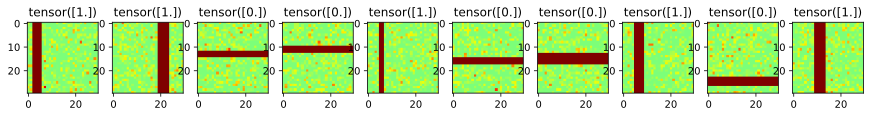

In [5]:
# visualize some images
fig,ax = plt.subplots(1,10,figsize=(15,3))

for i in range(10):
  whichpic = np.random.randint(N)
  ax[i].imshow(np.squeeze( images[whichpic,:,:] ),vmin=-1,vmax=1,cmap='jet')
  ax[i].set_title(f"{labels[whichpic]}")
plt.show()

In [6]:
print(images.shape)
print(labels.shape)

torch.Size([5000, 1, 30, 30])
torch.Size([5000, 1])


In [7]:
# Step 1: convert to tensor
dataT   = torch.tensor( images ).float()
labelsT = torch.tensor( labels ).float()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

/tmp/ipython-input-4125109384.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT   = torch.tensor( images ).float()
/tmp/ipython-input-4125109384.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor( labels ).float()


In [8]:
images, labels = next(iter(train_loader))
print(images.min().item(), images.max().item())  # 0.0 1.0

0.0 1.0


In [9]:
# create a class for the model
def createPsychoNet(printtoggle=False):

  class psychoNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (30+2*1-5)/1 )+1 = 28/2 = 14 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (14+2*1-5)/1 )+1 = 12/2 = 6 (/2 b/c maxpool)

      ### fully-connected layer
      self.fc1 = nn.Linear(6*6*20,50)

      ### output layer
      self.out = nn.Linear(50,1)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      x = torch.sigmoid(x)  # applies sigmoid element-wise
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = psychoNet(printtoggle)

  # loss function
  lossfun = nn.BCELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [10]:
# test the model with one batch
net,lossfun,optimizer = createPsychoNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 30, 30])
Layer conv1/pool1: torch.Size([32, 10, 14, 14])
Layer conv2/pool2: torch.Size([32, 20, 6, 6])
Vectorize: torch.Size([32, 720])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 1])
 
torch.Size([32, 1])
torch.Size([32, 1])
 
Loss:
tensor(0.6914, grad_fn=<BinaryCrossEntropyBackward0>)


In [11]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 5

  # create a new model
  net,lossfun,optimizer = createPsychoNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):
    print("epoch")

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      predlabels = yHat>.5
      # find errors
      misclassified = np.where(predlabels != y)[0]
      classified = np.where(predlabels == y)[0]

      # total accuracy
      totalacc = 100-100*len(misclassified)/(len(misclassified) + len(classified))
      batchAcc.append( totalacc )               # add to list of accuracies

      # compute accuracy
      #matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      #matchesNumeric = matches.float()             # convert to numbers (0/1)
      #accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( totalacc )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    predlabels = yHat>.5
    # find errors
    misclassified = np.where(predlabels != y)[0]
    classified = np.where(predlabels == y)[0]

    # total accuracy
    totalacct = 100-100*len(misclassified)/(len(misclassified) + len(classified))
    testAcc.append( totalacct )               # add to list of accuracies

    # compare the following really long line of code to the training accuracy lines
    #testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [12]:
trainAcc,testAcc,losses,net = function2trainTheModel()

epoch
epoch
epoch
epoch
epoch


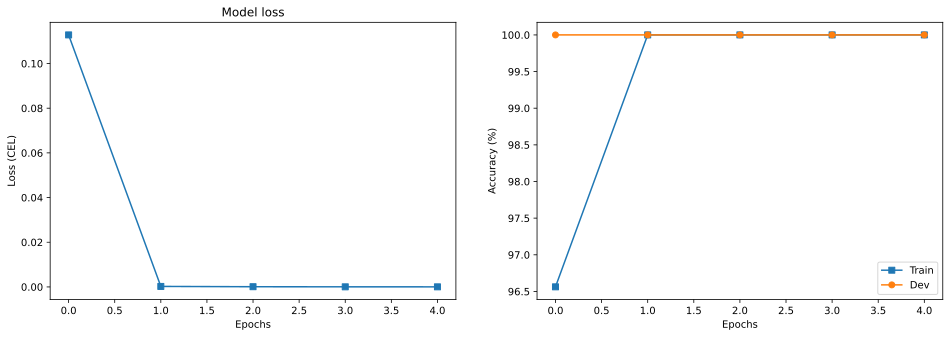

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-',label='Train')
#ax[0].plot(devLoss,'o-',label='Dev')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Dev')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()

plt.show()

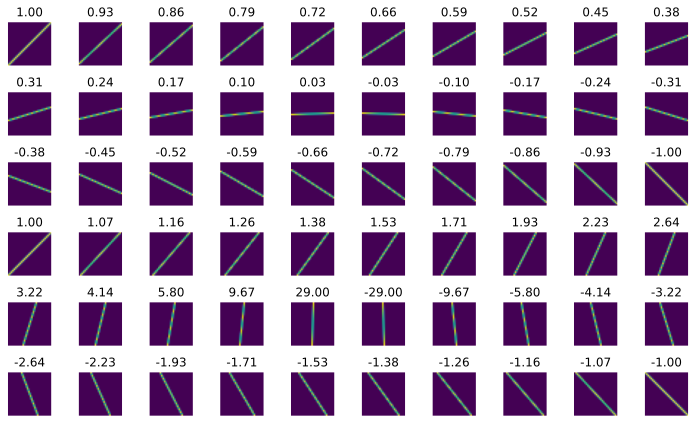

In [14]:
### create lines in images

from skimage.draw import line_aa

imgSize = 30

fig,ax = plt.subplots(6,10,figsize=(10,6))
imgs   = np.zeros((2*imgSize,1,imgSize,imgSize))
slopes = np.zeros(2*imgSize)

a = ax.flatten()
for i in range(imgSize):

  ### create lines with |slope|<1
  # point coords
  p1 = [0,i]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i,0,rows,cols] = val

  # plot
  a[i].imshow(imgs[i,0,:,:],origin='lower')
  a[i].set_title('%.2f'%slopes[i])
  a[i].axis('off')


  ### create lines with |slope|>1
  # point coords
  p1 = [i,0]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i+imgSize] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i+imgSize,0,rows,cols] = val

  # plot
  a[i+imgSize].imshow(imgs[i+imgSize,0,:,:],origin='lower')
  a[i+imgSize].set_title('%.2f'%slopes[i+imgSize])
  a[i+imgSize].axis('off')

plt.tight_layout()
plt.show()

In [36]:
print(imgs.shape)
print(slopes.shape)

(60, 1, 30, 30)
(60,)


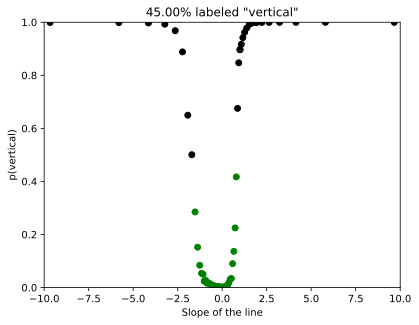

In [46]:
# run the images through the model

# randomly shuffle the images, just to be on the safe side...
# and also convert to tensor...
#ridx = np.random.permutation(range(imgs.shape[0]))
imgT = torch.tensor(imgs.astype(np.float32))


# now generate the prediction (horizontal or vertical)
net.eval()
yHat = net(imgT).detach()

# plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):
  if yHat[i]>.5:
    plt.plot(slopes[i],yHat[i],'ko')
  else:
    plt.plot(slopes[i],yHat[i],'go')
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title('%.2f%% labeled "vertical"' %torch.mean(100*(yHat>.5).float()).item())
plt.ylim([0,1])
plt.xlim([-10,10]) # note: this actually clips two data points
plt.show()

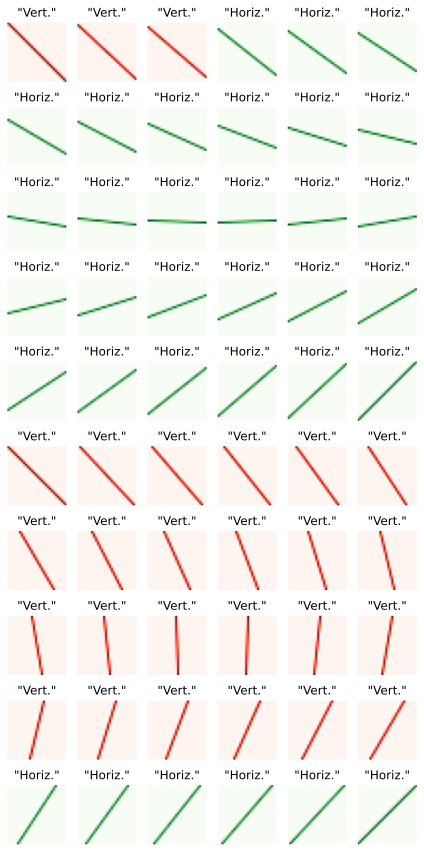

In [48]:
fig,ax = plt.subplots(10,6,figsize=(6,12))

for i,a in enumerate(ax.flatten()):

  # show the line-image (make sure to use the randomization index)
  if yHat[i]>.5:
    a.imshow(imgs[i,0,:,:],cmap='Reds')
  else:
    a.imshow(imgs[i,0,:,:],cmap='Greens')

  # and the title
  title = '"Vert."' if yHat[i].detach()>.5 else '"Horiz."'
  a.set_title(title)
  a.axis('off')

plt.tight_layout()
plt.show()